In [1]:
import pandas as pd
import numpy as np
import re
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import random
from probes import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")
import re
import pandas as pd
pd.set_option('display.max_columns', None)

/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# zip_file_path = '/Users/jessicakahn/Downloads/goodreads_reviews_dedup.json.gz'

In [4]:
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall('goodreads_data/') # Optional: specify a destination directory

In [3]:
df = pd.read_csv("goodreads_data/goodreads_samples.csv")

In [4]:
user_id_map = pd.read_csv("goodreads_data/user_id_map.csv")
book_id_map = pd.read_csv("goodreads_data/book_id_map.csv")

In [5]:
import json
with open('goodreads_data/book_data.json', 'r') as f:
    book_dict = json.load(f)

In [6]:
merged_df = pd.merge(df, book_id_map, left_on ='book_id',right_on='book_id_csv', how='left')

In [ ]:
# merged_df.head()

In [7]:
# Count ratings by user
totals = merged_df.groupby('user_id')['rating'].agg(lambda x: (x != 0).sum()).reset_index()

totals.columns = ['user_id','rating_count']
totals.head()

,user_id,rating_count
0,0,2
1,1,2
2,2,1
3,3,0
4,4,1


In [ ]:
# frequency_table = totals['rating'].value_counts()
# frequency_table

In [8]:
# want a row per user with a column for lists of ratings
# going to use this for gender??

merged_df2 = pd.merge(merged_df, totals[totals.rating_count >= 3], on ='user_id', how='inner')
result_df = merged_df2.groupby('user_id')['book_id_y'].agg(list).reset_index()

In [9]:
# result_df.shape
result_df.head(2)

,user_id,book_id_y
0,6,"[223380, 293299, 13513326]"
1,14,"[21462695, 24739687, 18799225, 17208961, 20613..."


In [10]:
# book_graph = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_books.json.gz"
# loaded on RACE to get book_dict

In [11]:
# merged_df['title'] = df['book_id'].apply(lambda x: 
# df['name'] = df['details'].apply(lambda x: x.get('name'))

In [12]:
book_dict['34684622']

{'title': 'Leonardo da Vinci',
 'title_without_series': 'Leonardo da Vinci',
 'isbn': '1501139150',
 'authors': [{'author_id': '7111', 'role': ''}],
 'language_code': 'eng'}

In [13]:
merged_df.head()

,user_id,book_id_x,is_read,rating,is_reviewed,book_id_csv,book_id_y
0,258795,337952,0,0,0,337952,26236831
1,35703,10266,0,0,0,10266,23007471
2,306704,68309,0,0,0,68309,8239387
3,28077,531408,0,0,0,531408,15804499
4,313420,82434,1,3,0,82434,682793


In [14]:
result_df.head(2)

,user_id,book_id_y
0,6,"[223380, 293299, 13513326]"
1,14,"[21462695, 24739687, 18799225, 17208961, 20613..."


In [15]:
book_dict['223380']

{'title': 'Stories of Your Life and Others',
 'title_without_series': 'Stories of Your Life and Others',
 'isbn': '0330426648',
 'authors': [{'author_id': '130698', 'role': ''}],
 'language_code': 'eng'}

In [16]:
with open('goodreads_data/author_data.json', 'r') as f:
    author_dict = json.load(f)

In [17]:
# Make prompts for gender classification

data_dict = {}
for i, row in result_df.iterrows():
    # sample 3 ids from list
    ids = random.sample(row.book_id_y, 3)
    # group recommendations for each user
    # title_list = []
    # author_list = []
    book_list = []
    for v in ids:
        title = book_dict[str(v)]['title']
        if len(book_dict[str(v)]['authors']) > 0:
            author_id = book_dict[str(v)]['authors'][0]['author_id']
            author_name = author_dict[author_id]
            book_list.append(f"{title} by {author_name}")
        else:
            book_list.append(title)
        
        
    prompt = f"""
    Hi, I've read and enjoyed the following books: {book_list[0]},  
    {book_list[1]}  and {book_list[2]}. """
    
    data_dict[row.user_id] = prompt
    
    

In [18]:
len(data_dict)

45764

In [19]:
# data_dict.keys()
data_dict[1077]

"\n    Hi, I've read and enjoyed the following books: A Storm of Swords (A Song of Ice and Fire, #3) by George R.R. Martin,  \n    Moth and Spark by Anne  Leonard  and From a Certain Point of View by Ben Acker. "

### Now put these prompts in to get annotated gender 

In [20]:
# Load the model
model_name = "meta-llama/Llama-3.2-3B-Instruct"  # Replace with your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.float32, device_map="auto")

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:08<00:00,  4.02s/it]
Some parameters are on the meta device because they were offloaded to the disk.


In [21]:
# Make a small sample of data_dict for testing
# small_data = {6:data_dict[6], 1077:data_dict[1077]}
# Get a list of (key, value) pairs
items = list(data_dict.items())

np.random.seed(42)
# Randomly sample the desired number of items
random_items = random.sample(items, 100)

# Create a new dictionary from the sampled items
new_dict = dict(random_items)

### 1. Get gender annotation by running the prompts through the model and asking it to predict gender

In [22]:
%%time
gender_dict = {}
max_new_tokens = 10
for k,v in new_dict.items():
    strings = [[{"role": "user", "content": v + "Based on these, can you please guess what my gender is? Please respond with only a single word as your answer."}]]  # single conversation
    inputs = tokenizer.apply_chat_template(
        strings[0],
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    inputs_dict = {"input_ids": inputs}
    with torch.inference_mode():
            output = model.generate(
            **inputs_dict,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
        )
    
    gender_text = tokenizer.decode(output[0], skip_special_tokens=True)
    # response_only = gender_text[len(v):].strip()
    split_text = re.sub(r'[^a-zA-Z]', '', gender_text.split(".assistant\n\n")[1])
    gender_dict[k] = split_text


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


CPU times: user 49.3 s, sys: 30min 20s, total: 31min 9s
Wall time: 55min 25s


In [23]:
# Make gender unknown if the llm didn't response
for k,v in gender_dict.items():
    if v not in ('Male', 'Female'):
        gender_dict[k] = 'Unknown'

In [24]:
# output gender dict to json
# file_path = "goodreads_data/gender_dict.json"
# with open(file_path, 'w') as json_file:
#     json.dump(gender_dict, json_file, indent=4)

In [ ]:
with open('goodreads_data/gender_dict.json', 'r') as f:
    gender_dict = json.load(f)

### 2. Get embeddings of prompts 

In [25]:
%%time 
# Need to add demo lookup in here
embedding_data_dict = {}
# Create keys with empty lists for each layer in hidden_states
for j in range(29):
    embedding_data_dict[j] = []
# Loop through and add demo + hidden_state to data_dict
for k,v in new_dict.items():
    inputs = tokenizer(v, return_tensors="pt").to("cpu")
    # Run forward pass and request hidden states
    with torch.inference_mode():
        outputs = model(
            **inputs,
            output_hidden_states=True,
            return_dict=True,
        )
    
    # Extract hidden states
    hidden_states = outputs.hidden_states

    # Lookup gender
    gender = gender_dict[k]
    for idx, repr in enumerate(hidden_states):
        # if idx >=20:
        embedding_data_dict[idx].append(dict(demo=gender, hidden=repr.mean(dim=1).squeeze(0)))

CPU times: user 13.5 s, sys: 7min 5s, total: 7min 18s
Wall time: 13min 33s


In [26]:
# type(embedding_data_dict[0][0]['hidden'])
# for key_layer, value in data_dict.items():
# type(data_dict[0])
# embedding_data_dict
len(embedding_data_dict[20])

100

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [124]:
(embedding_data_dict[0][2])['hidden'].shape

torch.Size([3072])

<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 'torch.Tensor'> torch.Size([76, 3072])
<class 'list'> <class 't

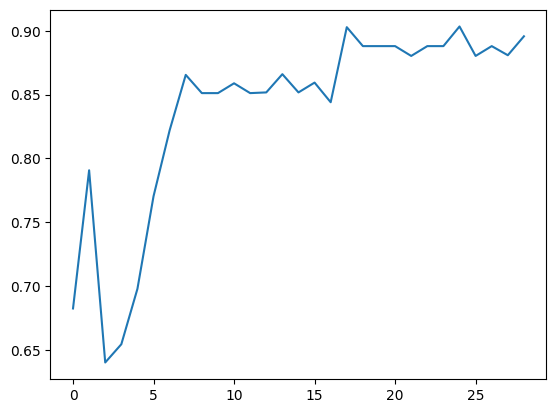

In [28]:
regress_list = []
results = []
# i = 0
for key_layer, value in embedding_data_dict.items():
    # if key_layer >= 20:
        # for j in value:
    X = [j['hidden'] for j in value if j['demo']!='Unknown']
    X_tensor = torch.stack(X)
    print(type(X), type(X[0]), X_tensor.shape)
    # i += 1
    # if i >= 1:
        # break
    y = [j['demo'] for j in value if j['demo']!='Unknown']
    # clf = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    clf = LogisticRegression()
    clf = clf.fit(X_tensor, y)

    scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
    # print('Layer: ', key_layer, ", Scores: ", scores)
    results.append(np.array(scores).mean())
    regress_list.append(clf)

plt.plot(results)

In [135]:
# probe_list = [0] * 19 + regress_list

In [30]:
# Dump probes
i = 0
for mod in regress_list:
    # save
    with open(f'goodreads_data/probes/model{i}.pkl','wb') as f:
        pickle.dump(mod,f)
    i+=1

In [27]:
probe_list = []
n_layers = 28
for i in range(n_layers):
    with open(f'goodreads_data/probes/model{i}.pkl','rb') as f:
        x = pickle.load(f)
        probe_list.append(x)

In [29]:
# probe_list

In [30]:
# This functions is from probes.ipynb
alpha = 1 # strength of steering
layer_to_steer = 27
max_new_tokens = 100
 #because only did the last few layers

def steer_prompt(p: str, alpha: int, layer_to_steer:int, max_new_tokens: int, probe_list:list) -> tuple:
    # This code takes in a single prompt, finds the hidden state in the final layer
    # then applies steering, using the probe coefficients (centered)
    
    # print('p: ' , p)

    # Prepare input
    strings = [[{"role": "user", "content": p + "Only return the 3 books you recommmend in a json format like {“Books”:[list of books]} and no other content. \n"}]]  # single conversation
    inputs = tokenizer.apply_chat_template(
        strings[0],
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    inputs_dict = {"input_ids": inputs}

    # Baseline generation
    # with torch.no_grad(): slower
    with torch.inference_mode():
        baseline_out = model.generate(
            **inputs_dict,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
        )

    baseline_text = tokenizer.decode(baseline_out[0], skip_special_tokens=True)
    print("=== BASELINE OUTPUT ===\n")
    print(baseline_text, "\n")

    # Steering probe 
    W = torch.tensor(probe_list[layer_to_steer].coef_, dtype=torch.float32, device=model.device)
    W_centered = W - W.mean(dim=0, keepdim=True)

    # Steering hook 
    def steering_hook(module, input, output):
        """ This hook does the steering """
        # output: [batch, seq_len, hidden_dim]
        hidden = output #[:, -1, :]  # last token hidden state
        x_proj0 = hidden @ W_centered.T
        x_proj = x_proj0 @ torch.linalg.pinv(W_centered).T
        v = -x_proj
        # steered = hidden + alpha * v
        # output[:, -1, :] = steered
        # Create a weighting mask that increases with token position
        seq_len = hidden.shape[1]
        # Example: linearly increasing weights from 0.1 to 1.0
        weights = torch.linspace(0.1, 1.0, seq_len, device=hidden.device)
        weights = weights.view(1, seq_len, 1)  # shape [1, seq_len, 1] for broadcasting
        
        # Apply position-dependent steering
        steered = hidden + alpha * weights * v
        return output

    
    handle = model.model.layers[layer_to_steer].register_forward_hook(steering_hook)


    # Steered Generation
    with torch.inference_mode():
    # with torch.no_grad() slower:
        steered_out = model.generate(
            **inputs_dict,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
        )

    handle.remove()  # clean up the hook

    steered_text = tokenizer.decode(steered_out[0], skip_special_tokens=True)

    print("=== STEERED OUTPUT ===\n")
    print(steered_text)
    return (baseline_text, steered_text)

# New hooks - trying to examine the hidden state before and after steering

In [31]:
# capture = {"pre": None, "post": None}
# def get_hidden_state2(module, input, output):
#     "This hook captures the hidden state"
#     if capture["pre"] is None:
#         capture["pre"] = output.detach().clone()
#     else:
#         capture["post"] = output.detach().clone()
#  # Steering hook 
# # def steering_hook2(module, input, output):
# #     """ This hook does the steering """
# #     # output: [batch, seq_len, hidden_dim]
# #     hidden = output #[:, -1, :]  # last token hidden state
# #     x_proj0 = hidden @ W_centered.T
# #     x_proj = x_proj0 @ torch.linalg.pinv(W_centered).T
# #     v = -x_proj
# #     # steered = hidden + alpha * v
# #     # output[:, -1, :] = steered
# #     # Create a weighting mask that increases with token position
# #     seq_len = hidden.shape[1]
# #     # Example: linearly increasing weights from 0.1 to 1.0
# #     weights = torch.linspace(0.1, 1.0, seq_len, device=hidden.device)
# #     weights = weights.view(1, seq_len, 1)  # shape [1, seq_len, 1] for broadcasting
    
# #     # Apply position-dependent steering
# #     steered = hidden + alpha * weights * v
# #     return output

In [145]:
# W = torch.tensor(probe_list[27].coef_, dtype=torch.float32, device=model.device)
# W_centered = W - W.mean(dim=0, keepdim=True)
# W == W.mean(dim=0, keepdim=True)
# W = torch.tensor(regress_list[layer_to_steer].coef_, dtype=torch.float32, device=model.device)
# W
model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.float32, device_map="auto")

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:17<00:00,  8.90s/it]
Some parameters are on the meta device because they were offloaded to the disk.


In [146]:
def steer_prompt_compare(
    prompt: str,
    alpha: float,
    layer_to_steer: int,
    max_new_tokens: int,
    probe_list: list
):
    """
    Runs baseline and steered generations for a single prompt.
    Captures pre- and post-steering hidden activations from a given layer.
    """

    # === Prepare model input ===
    chat = [[{"role": "user", "content": prompt + 
              " Only return the 3 books you recommend in JSON format like {\"Books\": {'title':..., 'author':...}}, and nothing else."}]]
    inputs = tokenizer.apply_chat_template(
        chat[0],
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)
    inputs_dict = {"input_ids": inputs}

    # === Run BASELINE (no steering) ===
    with torch.inference_mode():
        baseline_out = model.generate(
            **inputs_dict,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
        )
    baseline_text = tokenizer.decode(baseline_out[0], skip_special_tokens=True)
    print("=== BASELINE OUTPUT ===\n", baseline_text, "\n")

    # === Set up capture and steering for steered run ===
    capture = {"pre": None, "post": None}
    first_pass_done = {"value": False}

    def get_hidden_state_hook(module, input, output):
    # capture only the full-sequence hidden state
        if output.shape[1] == inputs.shape[1] and not first_pass_done["value"]:
            if capture["pre"] is None:
                capture["pre"] = output.detach().clone()


    def steering_hook(module, input, output):
    # steer only if it's the *initial full-sequence* forward
        if output.shape[1] == inputs.shape[1] and not first_pass_done["value"]:
            hidden = output
            W = torch.tensor(probe_list[layer_to_steer].coef_,
                             dtype=torch.float32, device=hidden.device)
            x_proj0 = hidden @ W.T
            x_proj = x_proj0 @ torch.linalg.pinv(W).T
            v = -x_proj
    
            seq_len = hidden.shape[1]
            weights = torch.linspace(0.5, 1.0, seq_len, device=hidden.device).view(1, seq_len, 1)
            steered = hidden + alpha * weights * v
    
            capture["post"] = steered.detach().clone()
            first_pass_done["value"] = True   # block all later decoding passes
            return steered
        else:
            return output


    # === Register hooks ===
    h1 = model.model.layers[layer_to_steer].register_forward_hook(get_hidden_state_hook)
    h2 = model.model.layers[layer_to_steer].register_forward_hook(steering_hook)
    h3 = model.model.layers[layer_to_steer].register_forward_hook(get_hidden_state_hook)

    # === Run STEERED generation ===
    with torch.inference_mode():
        steered_out = model.generate(
            **inputs_dict,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
        )

    # Clean up hooks
    h1.remove(); h2.remove(); h3.remove()

    # === Decode steered text ===
    steered_text = tokenizer.decode(steered_out[0], skip_special_tokens=True)
    print("=== STEERED OUTPUT ===\n", steered_text, "\n")

    # === Print shapes for sanity check ===
    print(f"Pre-steered shape:  {capture['pre'].shape if capture['pre'] is not None else None}")
    print(f"Post-steered shape: {capture['post'].shape if capture['post'] is not None else None}")

    # === Return results ===
    return {
        "baseline_text": baseline_text,
        "steered_text": steered_text,
        "pre_hidden": capture["pre"],
        "post_hidden": capture["post"],
    }


In [142]:
# new_dict[115098]
# probe_list[27]
# prompt

In [147]:
# gender_dict[227483]
# gender_dict
str_pr = "Hi, I've read and enjoyed the following books: Me before you by Jojo Moyes and It happened One Summer by Tessa Bailey. Can you please recommend some books I'd like. "

In [160]:
(new_dict[46163])

"\n    Hi, I've read and enjoyed the following books: The Secret Diaries of Charlotte Brontë by Syrie James,  \n    Gathering Blue (The Giver, #2) by Lois Lowry  and Rebel Angels (Gemma Doyle, #2) by Libba Bray. "

In [169]:
(al_dict[0.1]).keys()

dict_keys([46163, 360916, 279388, 301627, 333085, 321161, 221325, 10097, 285684, 230680, 217521, 328472, 181594, 216207, 189064, 224839, 190428, 45922, 407367, 151453, 40427, 117846, 3621, 373409, 181984, 114475, 10086, 428210, 185281, 227453, 94889, 415725, 253040, 260019, 112679, 1621, 212039, 76932, 53400, 227938, 381898, 134093, 121465, 436968, 203613, 163356, 197591, 212162, 351449, 291477, 369961, 90454, 122654, 203462, 134790, 124103, 435655, 123842, 275228, 87720, 441335, 282019, 391154, 276599, 128226, 431219, 55328, 394389, 156460, 176997, 144644, 265461, 135419, 300823, 59619, 353806, 159394, 266943, 308478, 343362, 178590, 425858, 389301, 396583, 374564, 102209, 436897, 14417, 23751, 31108, 21183, 424688, 49453, 252679, 61897, 14219, 281426, 192112, 407459, 287794])

In [165]:
torch.save(al_dict, 'alpha_dict.pt')

In [162]:
%%time
# new_dict[227483]
steer_compare_results = []
al_dict = {}
for al in  [0.1,0.5,1,5,10]:
    inner_dict = {}
    for k, v in new_dict.items():
        
        result = steer_prompt_compare(
            v,
            alpha=al,
            layer_to_steer=27,
            max_new_tokens=100,
            probe_list=regress_list,
        )
        inner_dict[k] = result
    al_dict[al] = inner_dict

=== BASELINE OUTPUT ===
 system

Cutting Knowledge Date: December 2023
Today Date: 07 Nov 2025

user

Hi, I've read and enjoyed the following books: The Secret Diaries of Charlotte Brontë by Syrie James,  
    Gathering Blue (The Giver, #2) by Lois Lowry  and Rebel Angels (Gemma Doyle, #2) by Libba Bray.  Only return the 3 books you recommend in JSON format like {"Books": {'title':..., 'author':...}}, and nothing else.assistant

{"Books": {"The Physick Book of Deliverance Dane", "The Age of Miracles", "The Night Circus"}} 

=== STEERED OUTPUT ===
 system

Cutting Knowledge Date: December 2023
Today Date: 07 Nov 2025

user

Hi, I've read and enjoyed the following books: The Secret Diaries of Charlotte Brontë by Syrie James,  
    Gathering Blue (The Giver, #2) by Lois Lowry  and Rebel Angels (Gemma Doyle, #2) by Libba Bray.  Only return the 3 books you recommend in JSON format like {"Books": {'title':..., 'author':...}}, and nothing else.assistant

{"Books": {
    "The Physick Book of D

In [149]:
# regress_list[27].coef_.shape
# type(result)
result.keys()

dict_keys(['baseline_text', 'steered_text', 'pre_hidden', 'post_hidden'])

In [150]:
# this has the pre and post steering hidden states in it
result['pre_hidden'].shape

torch.Size([1, 103, 3072])

In [151]:
result['post_hidden'].shape

torch.Size([1, 103, 3072])

In [153]:
# Compare logits for baseline and steered
# Get the hidden repr of the input, then apply the steering vector, 
unsteered = regress_list[28].predict_proba(result['pre_hidden'].mean(dim=1).squeeze(0).reshape(1, -1).detach().cpu().numpy())
steered = regress_list[28].predict_proba(result['post_hidden'].mean(dim=1).squeeze(0).reshape(1, -1).detach().cpu().numpy())

In [180]:
for k,v in al_dict.items():
    for key, result in v.items():
        b = regress_list[27].predict_proba(
            result['pre_hidden'].mean(dim=1).squeeze(0).reshape(1, -1).detach().cpu().numpy()
        )[0][0]
        result['unsteered_proba'] = b
        s = regress_list[27].predict_proba(
            result['post_hidden'].mean(dim=1).squeeze(0).reshape(1, -1).detach().cpu().numpy()
        )[0][0]
        result['steered_proba'] = s
    

In [247]:
((al_dict[0.5])[46163])['steered_proba']

np.float64(0.8339502959237848)

In [249]:
default_value = {}
small_dict = {key: {'baseline':[], 'steered':[]} for key in al_dict}
 # = {al_dict.keys()}
for k,v in al_dict.items(): #alpha values

    for key, value in v.items(): # user IDs
        for key1, value1 in value.items(): #values per user ID
            if key1 == 'unsteered_proba':
                small_dict[k]['baseline'].append(value1)
            elif key1 == 'steered_proba':
                small_dict[k]['steered'].append(value1)
                                            

In [255]:
# small_dict[0.1]['steered']

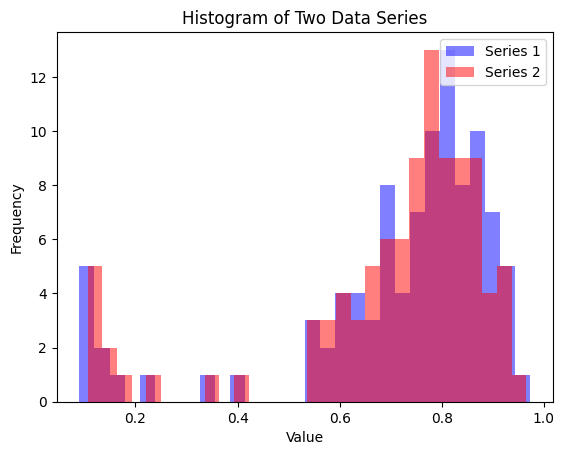

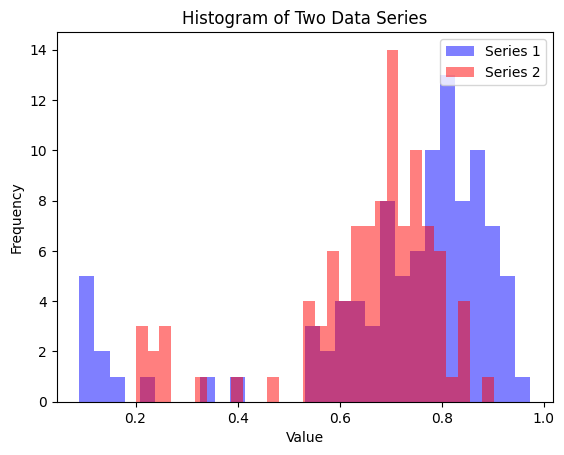

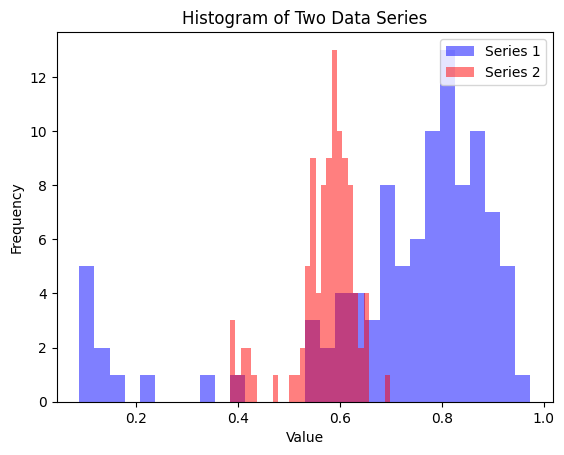

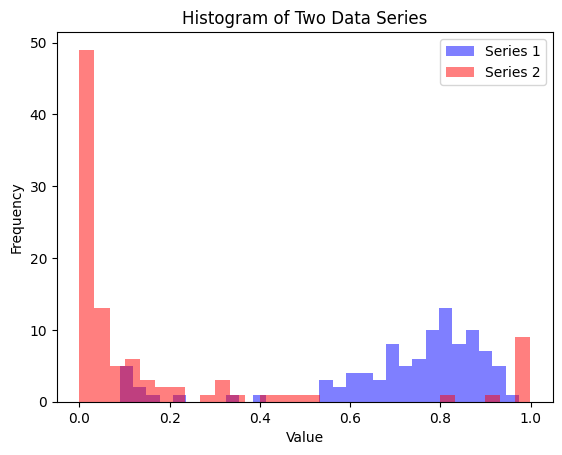

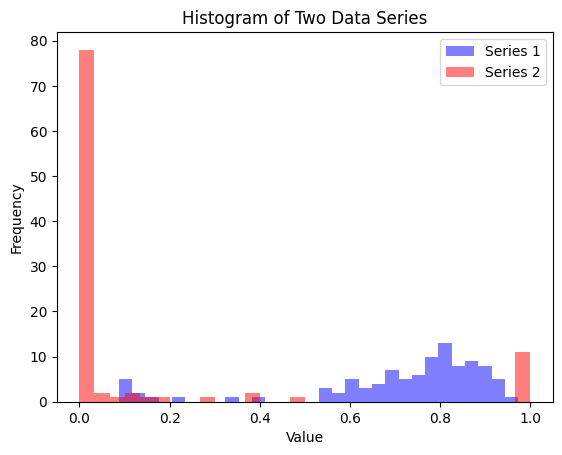

In [259]:
for k, v in small_dict.items():
# Create a figure and axes
    fig, ax = plt.subplots()
    
    # Plot the first histogram
    ax.hist(v['baseline'], bins=30, alpha=0.5, label='Series 1', color='blue')
    
    # Plot the second histogram on the same axes
    ax.hist(v['steered'], bins=30, alpha=0.5, label='Series 2', color='red')
    
    # Add a legend to distinguish the series
    ax.legend(loc='upper right')
    
    # Add titles and labels for clarity
    ax.set_title('Histogram of Two Data Series')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Display the plot
    plt.show()

In [193]:
df = pd.json_normalize(small_dict, sep='_')

In [194]:
df.columns

Index(['0.1_46163_baseline_text_baseline_text',
       '0.1_46163_baseline_text_steered_text',
       '0.1_46163_baseline_text_pre_hidden',
       '0.1_46163_baseline_text_post_hidden',
       '0.1_46163_baseline_text_unsteered_proba',
       '0.1_46163_baseline_text_steered_proba',
       '0.1_46163_steered_text_baseline_text',
       '0.1_46163_steered_text_steered_text',
       '0.1_46163_steered_text_pre_hidden',
       '0.1_46163_steered_text_post_hidden',
       ...
       '10_287794_unsteered_proba_pre_hidden',
       '10_287794_unsteered_proba_post_hidden',
       '10_287794_unsteered_proba_unsteered_proba',
       '10_287794_unsteered_proba_steered_proba',
       '10_287794_steered_proba_baseline_text',
       '10_287794_steered_proba_steered_text',
       '10_287794_steered_proba_pre_hidden',
       '10_287794_steered_proba_post_hidden',
       '10_287794_steered_proba_unsteered_proba',
       '10_287794_steered_proba_steered_proba'],
      dtype='object', length=12000)

In [154]:
unsteered = []

array([[0.94969175, 0.05030825]])

In [155]:
steered

array([[0.91910078, 0.08089922]])

In [88]:
# new_dict
# for k,v in new_dict.items():
    # for k,v in i.items():
    # print(v)

In [69]:
steered_list = []
for k,v in new_dict.items():
    # for k,v in i.items():
    # for j in v:
        # for prompt in j:
    gender = gender_dict[k]
    baseline, steered = steer_prompt(v,alpha,layer_to_steer, max_new_tokens, probe_list)
    steered_list.append(dict(demo=gender, baseline_output=baseline, steered_output=steered))

=== BASELINE OUTPUT ===

system

Cutting Knowledge Date: December 2023
Today Date: 03 Nov 2025

user

Hi, I've read and enjoyed the following books: Rogue (Shifters, #2) by Rachel Vincent,  
    Dead Ice (Anita Blake, Vampire Hunter, #24) by Laurell K. Hamilton  and The House of Winter (Circle of Three, #11) by Isobel Bird. Only return the 3 books you recommmend in a json format like {“Books”:[list of books]} and no other content.assistant

{"Books":["Moon Called (Mercy Thompson, #1) by Patricia Briggs","Bitten (Women of the Otherworld, #1) by Kelley Armstrong","Darkfever (Fever, #1) by Karen Marie Moning"} 

=== STEERED OUTPUT ===

system

Cutting Knowledge Date: December 2023
Today Date: 03 Nov 2025

user

Hi, I've read and enjoyed the following books: Rogue (Shifters, #2) by Rachel Vincent,  
    Dead Ice (Anita Blake, Vampire Hunter, #24) by Laurell K. Hamilton  and The House of Winter (Circle of Three, #11) by Isobel Bird. Only return the 3 books you recommmend in a json format li

In [73]:
type(steered_list[0])

dict

In [74]:
# rec_dict
# len(steered_list)
with open("goodreads_data/steered_output_100.json", "w") as f:
        json.dump(steered_list, f, indent=4) # indent for pretty-printing

In [ ]:
# gender_dict